# Astro 416 Final Project: Evan Rootness


# 1. Introduction

My project aims to deterine whether we can use Lick indices and machine learning to classify an object as a star or a globular star cluster (GC). We attempt to use a variety of models, with a focus however, on support vector machines (SVM).

For some background, Lick indices are a predefined set of equivalent widths that come from an object's spectra. And an equivalent width is essentially the width that is equivalent to that of an area under a spectrum's average continuum level, which has the same area as the flux "missing" due to an absorption line. For example, for the H-Beta Lick index, the difference between the average continuum level and the flux at each point along the absorption feature is summed to calculate the area in the line. Then this area is divided by the continuum level to find the equivalent width/Lick index. 

Our data comes from 3 papers: some of our stars from Robinson et al. 2007, the remaining stars from Sansom et al. 2013, and our GCs from Schiavon et al. 2012. Our datasets had varying number of indices, and we ended up choosing 10 of the indices that all 3 datasets had ('Ca4227', 'Fe4531', 'Fe5015', 'Fe5406', 'Fe4383', 'Fe5270', 'G4300', 'Hb', 'Mgb', 'NaD').

## Imports

In [1118]:
# import all necessary packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.metrics import make_scorer

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [ ]:
# data from papers
sansom_stars_df = pd.read_csv('data/sansom_stars_li.csv')
robinson_stars_df = pd.read_csv('data/robinson_stars_li.csv')
m31gcs_df = pd.read_csv('data/m31gcs_li.csv')

## Join and Clean dfs

In [565]:
# merge index names from all datasets
all_columns = np.append(m31gcs_df.columns.values, robinson_stars_df.columns.values)
all_columns = np.append(all_columns, sansom_stars_df.columns.values)

# check which indices are in all datasets
for name, count in zip(np.unique(all_columns, return_counts=True)[0], np.unique(all_columns, return_counts=True)[1]):
    print(name, 'count:', count)

C 24668 count: 1
C2-4668 count: 1
CN 1 count: 2
CN 2 count: 2
Ca 4455 count: 2
Ca4227 count: 3
Fe 4531 count: 3
Fe 4668 count: 1
Fe 5015 count: 3
Fe 5406 count: 3
Fe 5709 count: 2
Fe 5782 count: 2
Fe4383 count: 3
Fe5270 count: 3
Fe5335 count: 2
G4300 count: 3
HD count: 1
Hb count: 3
HdA count: 1
HdF count: 1
HgA count: 1
HgF count: 2
ID count: 1
M count: 1
Mg1 count: 2
Mg2 count: 3
Mgb count: 3
Mod count: 1
NaD count: 3
Name count: 1
No count: 1
Teff count: 1
Tel count: 1
TiO1 count: 2
TiO2 count: 2
Unnamed: 0 count: 3
[Fe/H] count: 1
[Mg/Fe] count: 1
e_C 24668 count: 1
e_CN 1 count: 1
e_CN 2 count: 1
e_Ca 4455 count: 1
e_Ca4227 count: 1
e_Fe 4531 count: 1
e_Fe 5015 count: 1
e_Fe 5406 count: 1
e_Fe 5709 count: 1
e_Fe 5782 count: 1
e_Fe4383 count: 1
e_Fe5270 count: 1
e_Fe5335 count: 1
e_G 300 count: 1
e_Hb count: 1
e_Mg1 count: 1
e_Mg2 count: 1
e_Mgb count: 1
e_NaD count: 1
e_TiO1 count: 1
e_TiO2 count: 1
logg count: 1


In [566]:
# correct column names to be consistent with each other
m31gcs_df.rename(columns={'Fe 4531': 'Fe4531', 'Fe 5015': 'Fe5015', 'Fe 5406': 'Fe5406'}, inplace=True)
robinson_stars_df.rename(columns={'Fe 4531': 'Fe4531', 'Fe 5015': 'Fe5015', 'Fe 5406': 'Fe5406'}, inplace=True)
sansom_stars_df.rename(columns={'Fe 4531': 'Fe4531', 'Fe 5015': 'Fe5015', 'Fe 5406': 'Fe5406'}, inplace=True)

In [567]:
# choose which lick indices to use/which indices we have available to use
lick_indices = ['Ca4227', 'Fe4531', 'Fe5015', 'Fe5406', 'Fe4383', 'Fe5270', 'G4300', 'Hb', 'Mgb', 'NaD']
# lick_indices = ['Fe5270', 'Hb']

# narrow down datasets to indices choosen above
m31gcs_limited = m31gcs_df.loc[:, lick_indices]
robinson_stars_limited = robinson_stars_df.loc[:, lick_indices]
sansom_stars_limited = sansom_stars_df.loc[:, lick_indices]

# add labels
m31gcs_limited['gc'] = np.full(len(m31gcs_limited), 1)
robinson_stars_limited['gc'] = np.full(len(robinson_stars_limited), 0)
sansom_stars_limited['gc'] = np.full(len(sansom_stars_limited), 0)

# concatenate all three dataframes
full_df = pd.concat([m31gcs_limited, robinson_stars_limited, sansom_stars_limited], axis=0)

Text(0, 0.5, 'Hb')

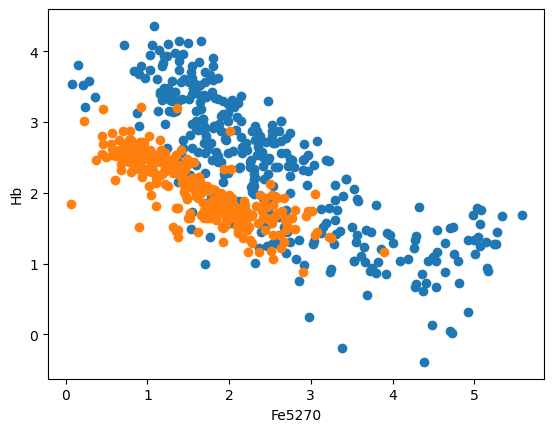

In [568]:
# check dataframe join worked successfully
plt.scatter(full_df['Fe5270'][full_df['gc'] == 0], full_df['Hb'][full_df['gc'] == 0])
plt.scatter(full_df['Fe5270'][full_df['gc'] == 1], full_df['Hb'][full_df['gc'] == 1])
plt.xlabel('Fe5270')
plt.ylabel('Hb')

Yes! We successfully combined the dataframes.

## Explore Data

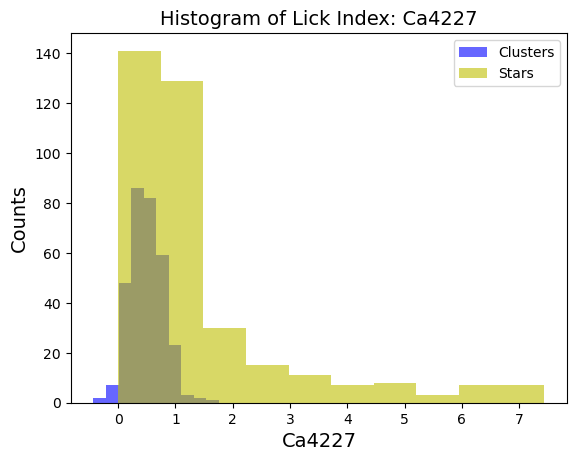

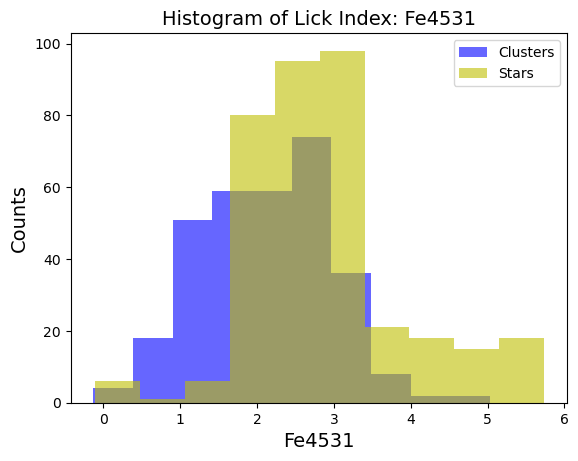

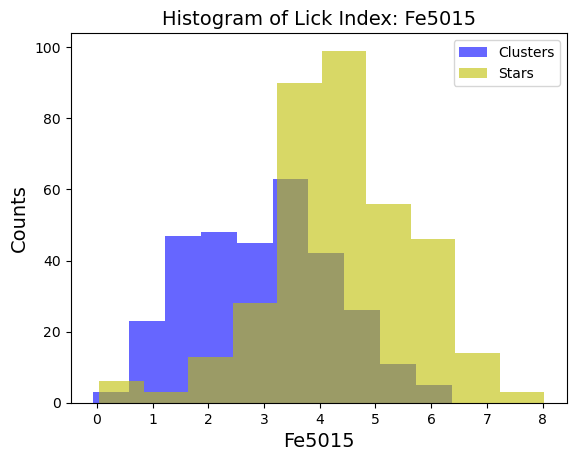

In [ ]:
# plot feature distributions of classes
for index in lick_indices[:3]:
    plt.title('Histogram of Lick Index: ' + index, fontsize=14)
    plt.hist(full_df[index][full_df['gc'] == 1], color='b', alpha=0.6, label='Clusters')
    plt.hist(full_df[index][full_df['gc'] == 0], color='y', alpha=0.6, label='Stars')
    plt.xlabel(index, fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.legend()
    plt.show()

Some of these distribution by themselves don't look helpful at all, others, like Fe5015, look promising even just by themselves.

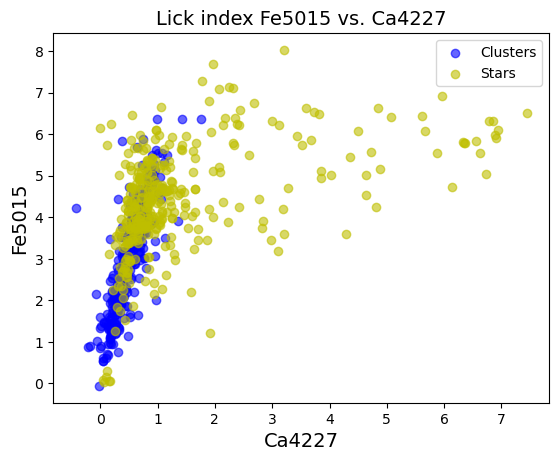

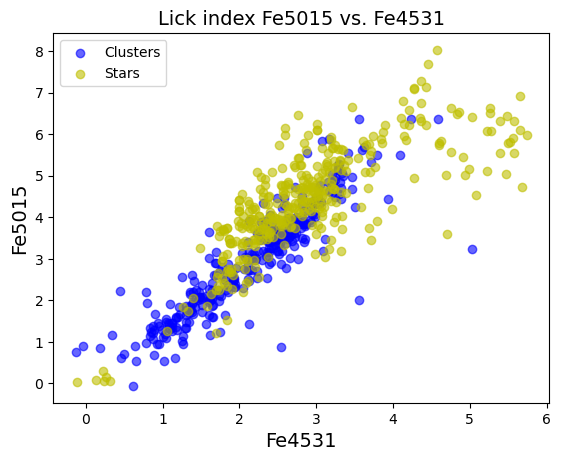

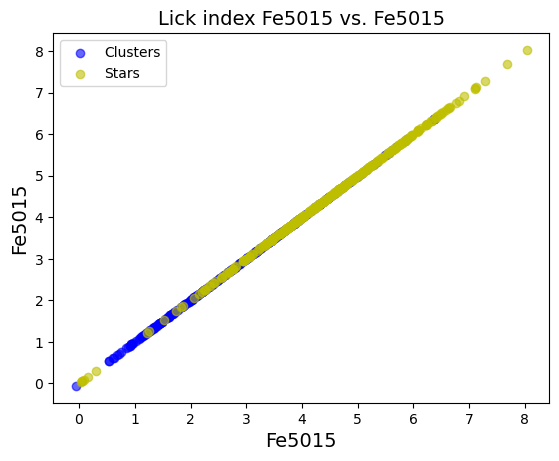

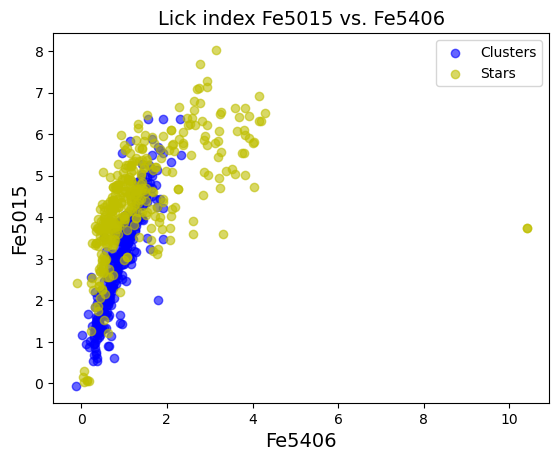

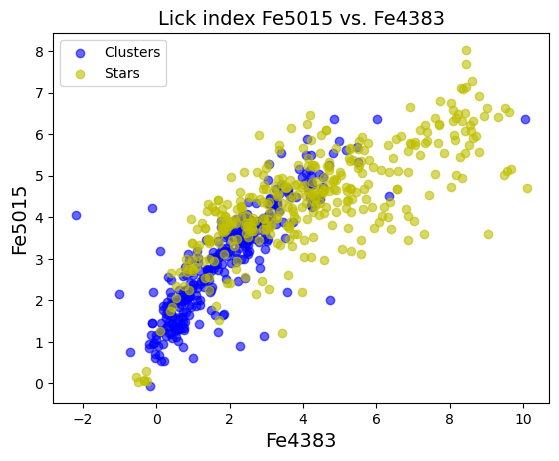

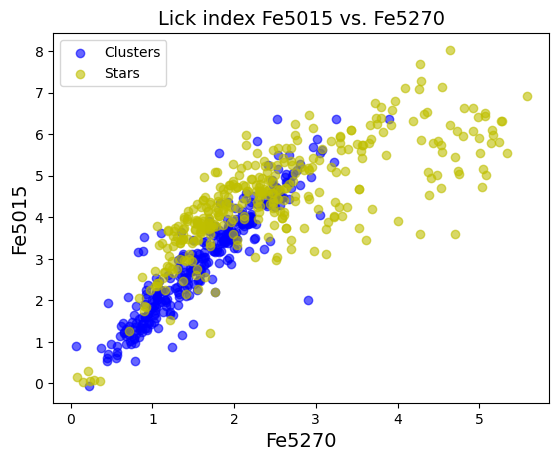

In [ ]:
# plot some 2D feature distributions
for index in lick_indices[:6]:
    # plt.plot(figsize=(3, 1))
    plt.title('Lick index Fe5015 vs. ' + index, fontsize=14)
    plt.scatter(full_df[index][full_df['gc'] == 1], full_df['Fe5015'][full_df['gc'] == 1], color='b', alpha=0.6, label='Clusters')
    plt.scatter(full_df[index][full_df['gc'] == 0], full_df['Fe5015'][full_df['gc'] == 0], color='y', alpha=0.6, label='Stars')
    plt.xlabel(index, fontsize=14)
    plt.ylabel('Fe5015', fontsize=14)
    plt.legend()
    plt.show()

Now we're getting better. Some of these 2D distributions look like we could put a circle/oval around the blue GCs and get a decent accuracy score.

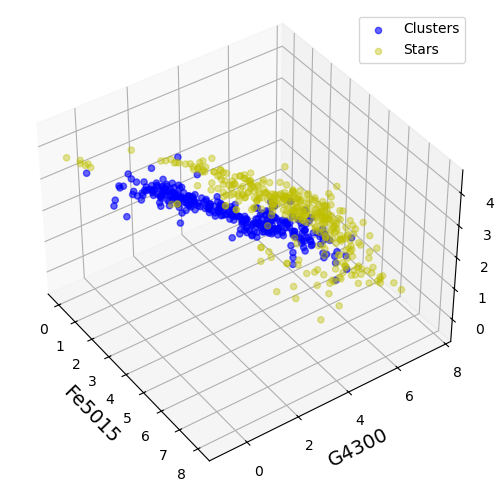

In [ ]:
# Create the figure and 3D axes
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=40, azim=-35, roll=0)

ax.scatter(full_df['Fe5015'][full_df['gc'] == 1], full_df['G4300'][full_df['gc'] == 1], full_df['Hb'][full_df['gc'] == 1], color='b', alpha=0.6, label='Clusters')
ax.scatter(full_df['Fe5015'][full_df['gc'] == 0], full_df['G4300'][full_df['gc'] == 0], full_df['Hb'][full_df['gc'] == 0], color='y', alpha=0.4, label='Stars')
ax.set_xlabel('Fe5015', fontsize=14)
ax.set_ylabel('G4300', fontsize=14)
ax.set_zlabel('H-beta', fontsize=14)
ax.legend()
plt.show()

Even better! The 3D distribution looks very promising from this angle. This gives us good confidence that by using 10 Lick indices, we will be able to separate the two classes pretty well.

It seems that hyperplanes would work very well, especially if we can put some regularization on it to account for the occasional overlaps between some instances.

## Split and Scale Data

In [27]:
# set x to be the lick indices
X = full_df.drop('gc', axis=1)
# set y to be the gc classification
y = full_df.loc[:, 'gc']

# split features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=91)

# check that the ratio of gcs to stars wasn't very far off original
print('Ratio of gcs to stars in full dataset:', np.sum(y == 1) / len(full_df))
print('Ratio of gcs to stars in train dataset', np.sum(y_train == 1) / len(y_train))
print('Ratio of gcs to stars in test dataset', np.sum(y_test == 1) / len(y_test))

# set up scaler
scaler = RobustScaler()
# fit and transform scaler to our training features
X_train_scaled = scaler.fit_transform(X_train)
# transform testing features as well (must not use when fitting scaler or some data leakage will occur)
X_test_scaled = scaler.transform(X_test)

Ratio of gcs to stars in full dataset: 0.46646795827123694
Ratio of gcs to stars in train dataset 0.464818763326226
Ratio of gcs to stars in test dataset 0.47029702970297027


# 2. Approach

To start, I tried 3 models to explore what architectures worked well and which didn't. As this problem involves splitting data points into classes, I thought that tree based models, like Decision Trees and Random Forests, would work well. I also thought that a Support Vector Machine (SVM) would work well, as it makes hyperplanes to separate classes. Finally, after trying those models, I also attempted to use Gaussian Mixture Models (GMM). I'll describe each of these algorithms a little bit here.

Decision Trees: Decision trees are relatively simple, but can be very effective since they can get relatively large. Essentially, they just split the data along a feature and into different classes to minimize the gini impurity (or whatever criterion is used). By making many splits, there are many branches to potential classes. With enough splits/branches which result in leaves where the class is set, decision trees can be quite effective for classification.

Random Forests: Random forests are ensembles of many decision tree models, which aggregate the results of all predicitors, which are usually pretty simple with few branches, to vote on a classification. Decision trees can be very effective, but when the data somewhat overlaps or is more complex, they might not be able to capture the trends of the data. By using many of these models that are each built differently, more complex trends can be captured, and it's what makes random forests sometimes better than single decision trees.

Support Vector Machines (SVM): SVMs use hyperplanes to split the data into classes. Because the hyperplanes can take on a variety of shapes, which is different from tree-based models which are straight cuts for each feature, the performance of SVMs can be better than tree-based models for some datasets.

Gaussian Mixture Models (GMM): GMMs assign a certain number of Gaussian distributions (number of classes) to the dataset, with different centroids, variances, and weights, to determine the overall density estimation of the data. This model works very well with prescribing each data point a probability of being in each class, so we want to try using it for this GC identification problem.


The features we use in this dataset are 10 Lick indices, which as described before are just the equivalent widths of different absorption lines in spectra. The target labels we use are the classification of if an object is a star (0) or a globular star cluster (1). The metrics we use for this problem are accuracy, precision, and recall, with an emphasis on recall. Since we are searching for new clusters, we would rather not miss any potential clusters. Therefore, we want to minimize false negatives, and this means we want to maximize recall. For grid searches we primarily focus on maximizing recall instead of accuracy or precision, but we do still evaluate those metrics after hyperparameter tuning.

# 3. Initial Results 
(Default Decision Tree, Random Forest, and SVM Models)

Our non-model benchmark value is the score we would get if we guessed all of the objects were the majority class (stars), which is about 53%. Of course, this would make our recall 0%, so this benchmark only really works when comparing accuracy, which is important to us, but recall and precision are also pretty critical for our problem.

Using the default parameters for our initial 3 models, we got pretty great results (recall of 0.90, 0.95, and 0.97 for the DT, RF, and SVM models). We can therefore conclude already that the training set is sufficient for these models, and we can solve this problem to a pretty high degree of certainty. The next steps to take are to optimize the models with some hyperparameter tuning (grid search), and then try using GMMs to get probabilities of each instance.

In [1040]:
print('Accuracy if guess is all stars:', accuracy_score(y_test, np.zeros(len(y_test))))

Accuracy if guess is all stars: 0.5297029702970297


In [1041]:
# set-up decision tree model with default parameters
dt_model = DecisionTreeClassifier(random_state=91)
# fit model to our scaled features and labels
dt_model.fit(X_train_scaled, y_train)
# create predictions of our test data
y_pred = dt_model.predict(X_test_scaled)
# print metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"f1 score: {f1_score(y_test, y_pred):.3f}")

Accuracy: 0.921
Precision: 0.934
Recall: 0.895
f1 score: 0.914


In [ ]:
# default random forest model
rf_model = RandomForestClassifier(random_state=91)
rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"f1 score: {f1_score(y_test, y_pred):.3f}")

Accuracy: 0.975
Precision: 1.000
Recall: 0.947
f1 score: 0.973


Accuracy: 0.985
Precision: 1.000
Recall: 0.968
f1 score: 0.984


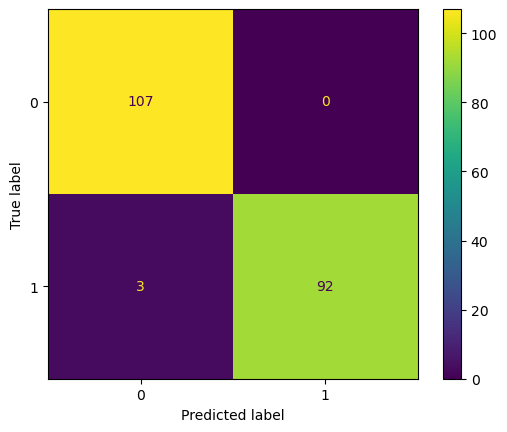

In [ ]:
# default SVM model
svc_model = SVC(random_state=91)
svc_model.fit(X_train_scaled, y_train)
y_pred = svc_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"f1 score: {f1_score(y_test, y_pred):.3f}")

# make confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=svc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_model.classes_)
disp.plot()

Wow, the default parameters for all 3 of these models worked very well. The training set is definitely sufficient in size, and recall is the best with the SVM model as we postulated earlier. (Keep in mind that these models were not cross-validated when comparing to the final cross-validation results later on)

*How did the benchmark (default) model parameter choices fare? Is your training set sufficient? Use diagnostic tools and plot visual aids that are relevant to your problem. What next steps are you going to take?*

# 3.5 Between Initial and Final Results

Now we should try running some grid searches and cross validations to tune these models a bit. We can also plot learning curves to see how the size of the dataset matters, and then also attempt using a Gaussian mixture model to get probabilities for each data point.

## Decision Tree Optimization

In [ ]:
# parameters to try in grid search
parameters = {'max_depth': [4, 6, 8], 'min_samples_leaf': [1, 2]}

# grid search with decision tree
grid_rf = GridSearchCV(DecisionTreeClassifier(criterion='gini', random_state=91), parameters, scoring=['recall'], refit='recall')
# fit grid search models
grid_rf.fit(X_train_scaled, y_train)

# output in nice dataframe format
pd.DataFrame(grid_rf.cv_results_).loc[:, ['params', 'mean_test_recall', 'std_test_recall', 'rank_test_recall']]

,params,mean_test_recall,std_test_recall,rank_test_recall
0,"{'max_depth': 4, 'min_samples_leaf': 1}",0.954228,0.029005,3
1,"{'max_depth': 4, 'min_samples_leaf': 2}",0.945137,0.046895,6
2,"{'max_depth': 6, 'min_samples_leaf': 1}",0.963425,0.030894,1
3,"{'max_depth': 6, 'min_samples_leaf': 2}",0.949683,0.041803,4
4,"{'max_depth': 8, 'min_samples_leaf': 1}",0.963425,0.030894,1
5,"{'max_depth': 8, 'min_samples_leaf': 2}",0.949683,0.041803,4


For this model, it seems that the random state can sometimes drastically alter the model. So, let's run a loop over a bunch of random states and take the averages.

In [ ]:
# grid search with decision tree
parameters = {'max_depth': [2, 6, 10, None], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2]}
grid_dt = GridSearchCV(DecisionTreeClassifier(criterion='gini', random_state=91), parameters, scoring=['recall'], refit='recall')
grid_dt.fit(X_train_scaled, y_train)
pd.DataFrame(grid_dt.cv_results_).loc[:, ['params', 'mean_test_recall', 'std_test_recall', 'rank_test_recall']]

,params,mean_test_recall,std_test_recall,rank_test_recall
0,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.816702,0.062142,19
1,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.816702,0.062142,19
2,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s...",0.816702,0.062142,19
3,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",0.816702,0.062142,19
4,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",0.816702,0.062142,19
5,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s...",0.816702,0.062142,19
6,"{'max_depth': 6, 'min_samples_leaf': 1, 'min_s...",0.963425,0.030894,1
7,"{'max_depth': 6, 'min_samples_leaf': 1, 'min_s...",0.963425,0.030894,1
8,"{'max_depth': 6, 'min_samples_leaf': 1, 'min_s...",0.949683,0.044205,7
9,"{'max_depth': 6, 'min_samples_leaf': 2, 'min_s...",0.949683,0.041803,7


In [ ]:
# setup array as empty
mean_recalls = None
parameters = {'max_depth': [2, 6, 10, None], 'criterion': ['gini'], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [1, 2]}

# need to average over many different random seeds to see the true average results for each set of parameters
for i in range(25):
    # grid search for a single random state
    grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=i), parameters, scoring=['recall'], refit='recall')
    grid_dt.fit(X_train_scaled, y_train)
    new_col = grid_dt.cv_results_['mean_test_recall'][:, np.newaxis]
    # if on first iteration, set array to new_col, else append new_col
    if mean_recalls is None:
        mean_recalls = new_col
    else:
        mean_recalls = np.append(mean_recalls, new_col, axis=1)
    # mean_recalls = np.append(mean_recalls, np.array([grid_dt.cv_results_['mean_test_recall']]).T, axis=1)
    param_list = grid_dt.cv_results_['params']

# take mean and stdev of these grid search results
means = mean_recalls.mean(axis=1)
stds = mean_recalls.std(axis=1)

# print out results
for i, params in enumerate(param_list):
    print(params, round(means[i], 3), '+-', round(stds[i], 3))

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.817 +- 0.0
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4} 0.817 +- 0.0
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 6} 0.817 +- 0.0
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2} 0.817 +- 0.0
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 4} 0.817 +- 0.0
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 6} 0.817 +- 0.0
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.956 +- 0.005
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 4} 0.956 +- 0.005
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6} 0.95 +- 0.004
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2} 0.945 +- 0.007
{'criterion':

Ok, these look really good. It seems that max_depth just has to be at or above around 6. min_samples_leaf=1 is best. min_samples_split doesn't change much, and is better at lower numbers (so let's stick with 2).

Let's run this again, and now look between the different choices of criterion to see if something other than 'gini' is better.

In [ ]:
mean_recalls = None
parameters = {'max_depth': [6, None], 'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_leaf': [1]}

# need to average over different random seeds to see the true average results for each set of parameters
for i in range(25):

    grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=i), parameters, scoring=['recall'], refit='recall')
    grid_dt.fit(X_train_scaled, y_train)
    new_col = grid_dt.cv_results_['mean_test_recall'][:, np.newaxis]

    # if on first iteration, set array to new_col, else append new_col
    if mean_recalls is None:
        mean_recalls = new_col
    else:
        mean_recalls = np.append(mean_recalls, new_col, axis=1)
    # mean_recalls = np.append(mean_recalls, np.array([grid_dt.cv_results_['mean_test_recall']]).T, axis=1)
    param_list = grid_dt.cv_results_['params']

means = mean_recalls.mean(axis=1)
stds = mean_recalls.std(axis=1)

for i, params in enumerate(param_list):
    print(params, round(means[i], 3), '+-', round(stds[i], 3))

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1} 0.956 +- 0.005
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1} 0.956 +- 0.005
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1} 0.951 +- 0.004
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1} 0.951 +- 0.004
{'criterion': 'log_loss', 'max_depth': 6, 'min_samples_leaf': 1} 0.951 +- 0.004
{'criterion': 'log_loss', 'max_depth': None, 'min_samples_leaf': 1} 0.951 +- 0.004


So 'gini' is indeed the best criterion to use for this problem.

In [ ]:
# constructing our final, best decision tree model with CV
cv_results_array = None

for i in range(50):
    # create best model based on our grid searches
    dt_model = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_leaf=1, random_state=i)
    cv_results = cross_validate(dt_model, X_train_scaled, y_train, cv=5, scoring=('accuracy', 'precision', 'recall'))
    # create the new column to add, np.newaxis helps set this up
    new_col = pd.DataFrame(cv_results).mean(axis=0).iloc[2:5].values[:, np.newaxis]

    # if on first iteration, set array to new_col, else append new_col
    if cv_results_array is None:
        cv_results_array = new_col
    else:
        cv_results_array = np.append(cv_results_array, new_col, axis=1)

acc_prec_rec = ['accuracy', 'precision', 'recall']

for i, score in enumerate(acc_prec_rec):
    print(score, 'score:', round(cv_results_array.mean(axis=1)[i], 4), '+-', round(cv_results_array.std(axis=1)[i], 3))

accuracy score: 0.9634 +- 0.004
precision score: 0.9656 +- 0.007
recall score: 0.9567 +- 0.006


In [1099]:
# best model after grid search
dt_best_model = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_leaf=1, random_state=91)
dt_best_model.fit(X_train_scaled, y_train)
y_pred = dt_best_model.predict(X_test_scaled)
print('Best Decision Tree Model Metrics')
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"f1 score: {f1_score(y_test, y_pred):.3f}")

Best Decision Tree Model Metrics
Accuracy: 0.921
Precision: 0.934
Recall: 0.895
f1 score: 0.914


## Random Forest Optimization

In [ ]:
mean_recalls = None
parameters = {'n_estimators': [100, 1000], 'max_depth': [5, 10, None]}

# need to average over different random seeds to see the true average results for each set of parameters
# random forest takes a lot longer to run, so i'm only using 3 different seeds here
for i in range(3):
    grid_rf = GridSearchCV(RandomForestClassifier(random_state=i), parameters, scoring=['recall'], refit='recall')
    grid_rf.fit(X_train_scaled, y_train)
    new_col = grid_rf.cv_results_['mean_test_recall'][:, np.newaxis]
    # if on first iteration, set array to new_col, else append new_col
    if mean_recalls is None:
        mean_recalls = new_col
    else:
        mean_recalls = np.append(mean_recalls, new_col, axis=1)
    param_list = grid_rf.cv_results_['params']

means = mean_recalls.mean(axis=1)
stds = mean_recalls.std(axis=1)

for i, params in enumerate(param_list):
    print(params, round(means[i], 3), '+-', round(stds[i], 3))

{'max_depth': 5, 'n_estimators': 100} 0.966 +- 0.004
{'max_depth': 5, 'n_estimators': 1000} 0.966 +- 0.002
{'max_depth': 10, 'n_estimators': 100} 0.965 +- 0.004
{'max_depth': 10, 'n_estimators': 1000} 0.968 +- 0.004
{'max_depth': None, 'n_estimators': 100} 0.965 +- 0.004
{'max_depth': None, 'n_estimators': 1000} 0.968 +- 0.004


In [ ]:
mean_recalls = None
parameters = {'n_estimators': [10, 100, 1000, 3000]}

# need to average over different random seeds to see the true average results for each set of parameters
# random forest takes a lot longer to run, so i'm only using 3 different seeds here
for i in range(3):
    grid_rf = GridSearchCV(RandomForestClassifier(random_state=i), parameters, scoring=['recall'], refit='recall')
    grid_rf.fit(X_train_scaled, y_train)
    new_col = grid_rf.cv_results_['mean_test_recall'][:, np.newaxis]
    # if on first iteration, set array to new_col, else append new_col
    if mean_recalls is None:
        mean_recalls = new_col
    else:
        mean_recalls = np.append(mean_recalls, new_col, axis=1)
    param_list = grid_rf.cv_results_['params']

means = mean_recalls.mean(axis=1)
stds = mean_recalls.std(axis=1)

for i, params in enumerate(param_list):
    print(params, round(means[i], 3), '+-', round(stds[i], 3))

{'n_estimators': 10} 0.956 +- 0.014
{'n_estimators': 100} 0.965 +- 0.004
{'n_estimators': 1000} 0.968 +- 0.004
{'n_estimators': 3000} 0.968 +- 0.0


The recall scores don't really change with max_depth, and get better with more n_estimators. Let's set n_estimators=1000. It doesn't seem like the random forest is going to change a whole lot with tuning, and its score is already very good.

In [1071]:
# best random forest model with varying seeds
cv_results_array = None

for i in range(10):
    # create best model based on our grid searches
    rf_model = RandomForestClassifier(n_estimators=1000, random_state=i)
    cv_results = cross_validate(rf_model, X_train_scaled, y_train, cv=5, scoring=('accuracy', 'precision', 'recall'))
    # create the new column to add, np.newaxis helps set this up
    new_col = pd.DataFrame(cv_results).mean(axis=0).iloc[2:5].values[:, np.newaxis]

    # if on first iteration, set array to new_col, else append new_col
    if cv_results_array is None:
        cv_results_array = new_col
    else:
        cv_results_array = np.append(cv_results_array, new_col, axis=1)

acc_prec_rec = ['accuracy', 'precision', 'recall']

for i, score in enumerate(acc_prec_rec):
    print(score, 'score:', round(cv_results_array.mean(axis=1)[i], 4), '+-', round(cv_results_array.std(axis=1)[i], 3))

accuracy score: 0.981 +- 0.001
precision score: 0.9918 +- 0.003
recall score: 0.9675 +- 0.003


In [1068]:
# best model after grid search
rf_best_model = RandomForestClassifier(n_estimators=1000, random_state=91)
rf_best_model.fit(X_train_scaled, y_train)
y_pred = rf_best_model.predict(X_test_scaled)
print('Best Random Forest Model Metrics')
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"f1 score: {f1_score(y_test, y_pred):.3f}")

Best Random Forest Model Metrics
Accuracy: 0.980
Precision: 1.000
Recall: 0.958
f1 score: 0.978


## SVM Optimization

In [ ]:
# grid search with SVM classifier to get best parameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=91)
# parameters = {'kernel':('linear', 'rbf', 'sigmoid', 'poly'), 'C':[1, 10, 100, 1000]}
parameters = {'kernel': ['linear', 'rbf', 'sigmoid'], 'C':[1, 10], 'gamma':['scale', 1]}#, 'degree':[2, 3, 4]}
grid_svc = GridSearchCV(SVC(), parameters, scoring=['accuracy', 'recall', 'precision'], refit='recall', return_train_score=True, cv=cv)
grid_svc.fit(X_train_scaled, y_train)
grid_df = pd.DataFrame(grid_svc.cv_results_)
grid_df[['params', 'mean_train_accuracy', 'mean_test_accuracy', 'mean_train_recall', 'mean_test_recall', 'rank_test_recall', 'mean_train_precision', 'mean_test_precision', 'rank_test_precision']]

,params,mean_train_accuracy,mean_test_accuracy,mean_train_recall,mean_test_recall,rank_test_recall,mean_train_precision,mean_test_precision,rank_test_precision
0,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.987204,0.978678,0.985090,0.977167,3,0.987356,0.976956,7
1,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.991471,0.987211,0.991974,0.986364,1,0.989708,0.986258,4
2,"{'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}",0.660973,0.656646,0.608952,0.591649,12,0.642864,0.644919,12
3,"{'C': 1, 'gamma': 1, 'kernel': 'linear'}",0.987204,0.978678,0.985090,0.977167,3,0.987356,0.976956,7
4,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",1.000000,0.978723,1.000000,0.954334,8,1.000000,1.000000,1
5,"{'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}",0.696689,0.688652,0.680053,0.670296,9,0.671748,0.664393,11
6,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.991470,0.974422,0.988532,0.968076,5,0.993096,0.977158,5
7,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.998933,0.993617,0.997701,0.986364,1,1.000000,1.000000,1
8,"{'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}",0.706316,0.697072,0.679810,0.647463,11,0.684475,0.680559,9
9,"{'C': 10, 'gamma': 1, 'kernel': 'linear'}",0.991470,0.974422,0.988532,0.968076,5,0.993096,0.977158,5


From this grid search the hyperparameters don't seemt to have too much effect on the model, besides the kernel, which is definitely best being 'rbf'. We can take C=1 and gamma='scale' to be the best hyperparameters, as they have good scores and make the model relatively simple.

In [1030]:
# constructing our final, best svm model
cv_results_array = None

for i in range(10):
    # create best model based on our grid searches
    svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=i)
    cv_results = cross_validate(svm_model, X_train_scaled, y_train, cv=5, scoring=('accuracy', 'precision', 'recall'))
    # create the new column to add, np.newaxis helps set this up
    new_col = pd.DataFrame(cv_results).mean(axis=0).iloc[2:5].values[:, np.newaxis]

    # if on first iteration, set array to new_col, else append new_col
    if cv_results_array is None:
        cv_results_array = new_col
    else:
        cv_results_array = np.append(cv_results_array, new_col, axis=1)

acc_prec_rec = ['accuracy', 'precision', 'recall']

print('Best SVM Metrics')
for i, score in enumerate(acc_prec_rec):
    print(score, 'score:', round(cv_results_array.mean(axis=1)[i], 4), '+-', round(cv_results_array.std(axis=1)[i], 10))

Best SVM Metrics
accuracy score: 0.9872 +- 0.0
precision score: 0.9866 +- 0.0
recall score: 0.9864 +- 0.0


In [1115]:
# best model after grid search
svc_best_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=91)
svc_best_model.fit(X_train_scaled, y_train)
y_pred = svc_best_model.predict(X_test_scaled)
print('Best SVM Model Metrics')
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"f1 score: {f1_score(y_test, y_pred):.3f}")

Best SVM Model Metrics
Accuracy: 0.985
Precision: 1.000
Recall: 0.968
f1 score: 0.984


The random_state does not even change the SVM results, so we don't have to worry about that. And overall, the metrics are all very good for this best SVM model.

## Learning Curves of 3 Main Models

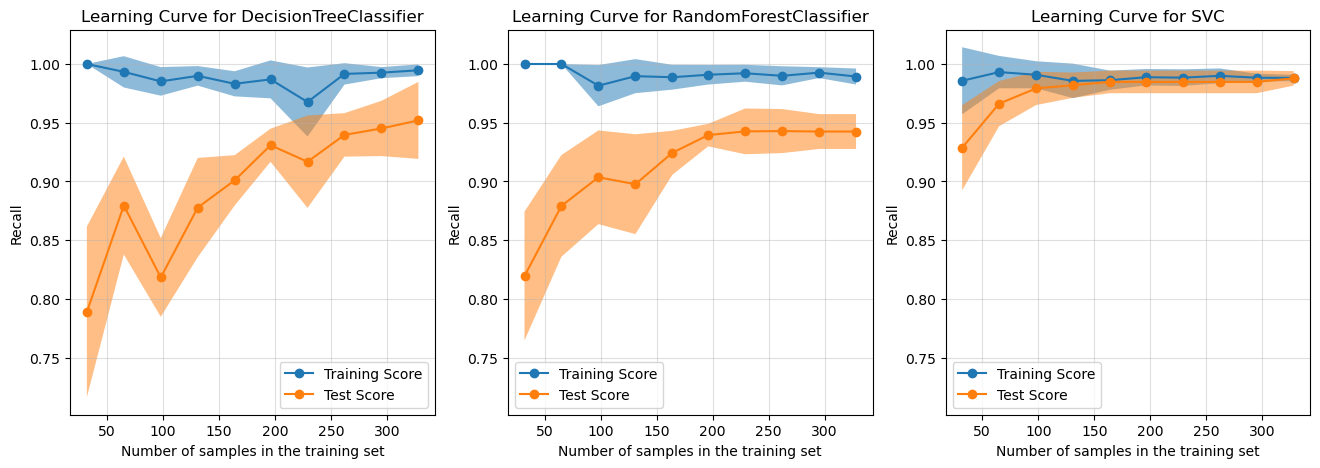

In [ ]:
# make a scorer for the recall score
recall_scorer = make_scorer(recall_score)

# set up subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), sharey=True)

# set up parameters for each learning curve
common_params = {
    "X": X_train_scaled,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=5, test_size=0.3, random_state=91),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Recall",
    "scoring": recall_scorer
}

# make models, with tree-based models having max depth so training scores aren't always 1.0
dt = DecisionTreeClassifier(max_depth=4)
rf = RandomForestClassifier(max_depth=4)
svc = SVC()

# plot learning curves
for ax_idx, estimator in enumerate([dt, rf, svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")
    ax[ax_idx].yaxis.get_label().set_visible(True)
    ax[ax_idx].tick_params(axis='y', labelleft=True)
    ax[ax_idx].grid(alpha=0.4)

The learning curves show that from the get-go, SVM is superior to both tree-based models. It also performs better when the full dataset is used.

## SVM Hyperplane Figure

In [791]:
# function to show the hyperplace of a two feature svm
def plot_training_data_with_decision_boundary(kernel, X, y, model, ax=None, long_title=True, support_vectors=True):
    # # Settings for plotting
    if ax is None:
        _, ax = plt.subplots(figsize=(4*1.5, 3*1.5))
    # x_min, x_max, y_min, y_max = -3, 3, -3, 3
    # ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    # ax.set(xlim=(X[:, 0].min() - 1, X[:, 0].max() + 1), ylim=(X[:, 1].min() - 1, X[:, 1].max() + 1))
    ax.set(xlim=(X[:, 0].min(), X[:, 0].max()), ylim=(X[:, 1].min(), X[:, 1].max()))

    # Plot decision boundary and margins
    common_params = {"estimator": model, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(**common_params, response_method="predict", plot_method="pcolormesh", alpha=0.3)
    DecisionBoundaryDisplay.from_estimator(**common_params, response_method="decision_function", plot_method="contour", levels=[-1, 0, 1], colors=["k", "k", "k"], linestyles=["--", "-", "--"])

    if support_vectors:
        # Plot bigger circles around samples that serve as support vectors
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=150, facecolors="none", edgecolors="k")

    # Plot samples by color and add legend
    colors = {0: 'y', 1: 'b'}
    # ax.scatter(X[:, 0], X[:, 1], c=y, s=30, edgecolors="k")
    scatter = ax.scatter(X[:, 0], X[:, 1], c=[colors.get(label) for label in y], s=15, edgecolors="k", linewidth=0.5)
    ax.scatter(-100, -100, c='b', s=20, edgecolors="k", linewidth=0.5, label='Clusters')
    ax.scatter(-100, -100, c='y', s=20, edgecolors="k", linewidth=0.5, label='Stars')
    # ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.set_xlabel('[Fe5270]')
    ax.set_ylabel(r'[$H\beta$]')
    ax.legend(title='Classes')
    if long_title:
        ax.set_title(f" Decision boundaries of rbf kernel in SVC")
    else:
        ax.set_title(kernel)

    if ax is None:
        plt.show()

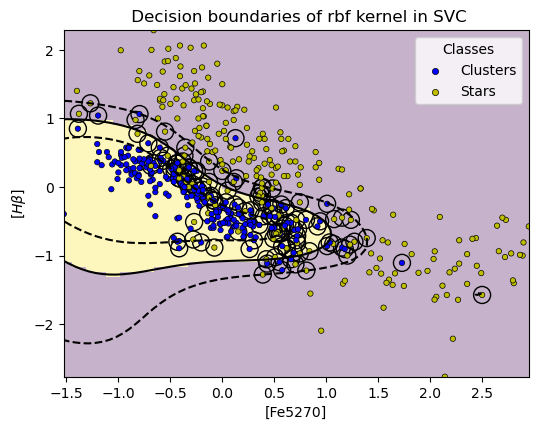

In [802]:
# create model to use with only two features
svc_model_two_feats = SVC(kernel='rbf', C=10, gamma='scale')
svc_model_two_feats.fit(X_train_scaled[:, [5, 7]], y_train)
plot_training_data_with_decision_boundary('rbf', X_train_scaled[:, [5, 7]], y_train, svc_model_two_feats)

This plot of the SVM hyperplane when just two features are used. We can see that the radial basis function has a clump around the clusters, and then everything else is classified as stars. This is a pretty effective method, and the plot helps illustrate this.

## GMM

We now want to try making a Gaussian Mixture Model, so that we can get the probabilities of each instance. This will be helpful for any new candidates we have and want to confirm or deny if they are a GC.

Accuracy: 0.401
Precision: 0.250
Recall: 0.137
f1 score: 0.177


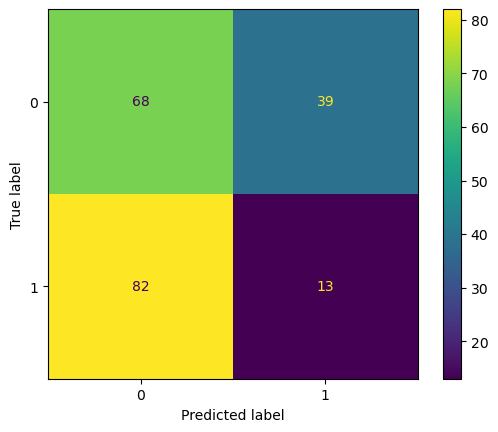

In [ ]:
# train and evaluate GMM model
gmm_model = GaussianMixture(n_components=2, random_state=91, covariance_type='full', init_params='k-means++')
gmm_model.fit(X_train_scaled, y_train)
y_pred = gmm_model.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"f1 score: {f1_score(y_test, y_pred):.3f}")

# make and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

The results from the default GMM look pretty bad off the bat. Let's try using PCA on our data first.

[0.79477861 0.10973554 0.03136214 0.02614526 0.01540253 0.00926395
 0.00616434 0.0037654  0.0024481  0.00093412]


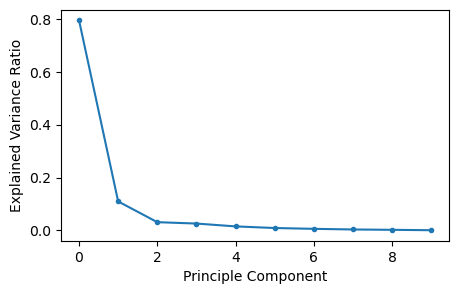

In [200]:
# Try PCA for GMM
n_comps = 10

# fit training feature data with PCA and plot explained variance ratio to see how many components we really need
pca = PCA(n_components=n_comps)
pca.fit(X_train)
plt.figure(figsize=(5, 3))
plt.errorbar(range(n_comps), pca.explained_variance_ratio_, fmt='.-')
plt.xlabel('Principle Component')
plt.ylabel('Explained Variance Ratio')
print(pca.explained_variance_ratio_)
plt.show()

# get cluster and star indices
cluster_idx = y_train == 1
star_idx = y_train == 0

# transform feature data into principle components
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# robust scale feature data
# set up scaler
scaler = RobustScaler()
# fit and transform scaler to our training features
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
# transform testing features as well (must not use when fitting scaler or some data leakage will occur)
X_test_pca_scaled = scaler.transform(X_test_pca)

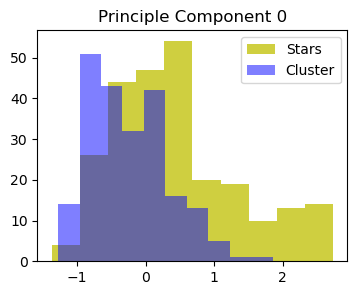

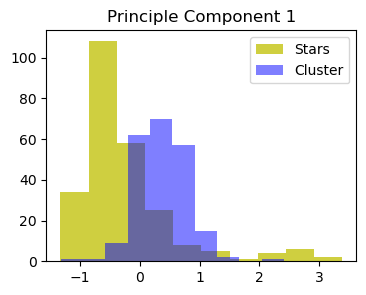

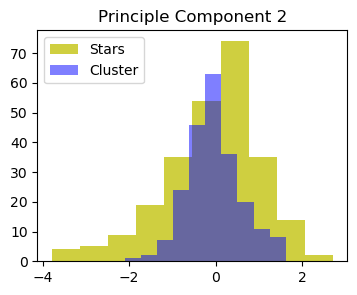

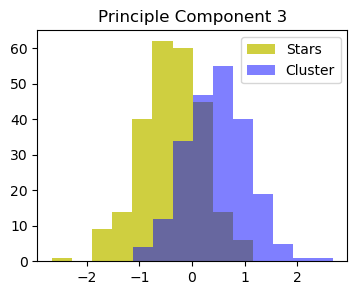

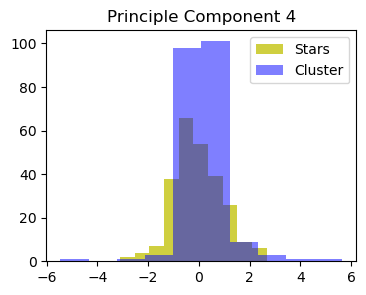

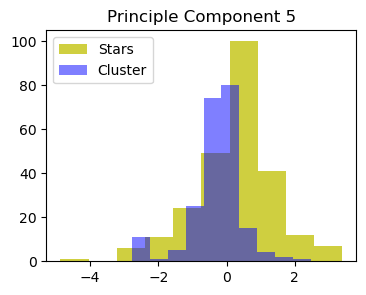

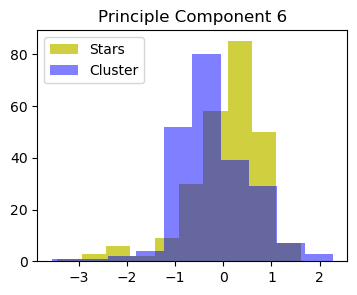

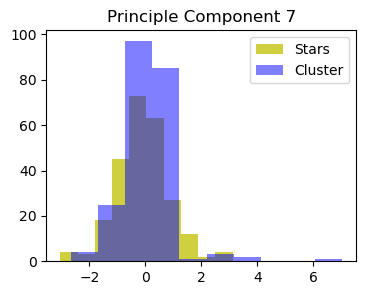

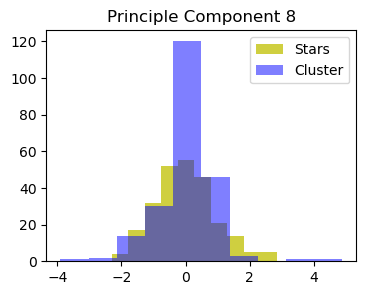

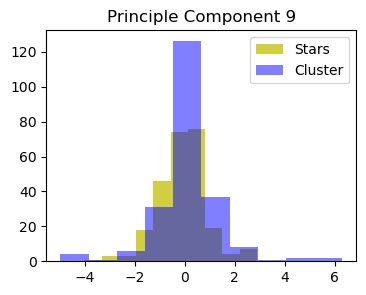

In [ ]:
# plot principle component distributions of classes
for i in range(n_comps):
    plt.figure(figsize=(4, 3))
    plt.hist(X_train_pca_scaled[star_idx, i], color='y', alpha=0.75, label='Stars')
    plt.hist(X_train_pca_scaled[cluster_idx, i], color='b', alpha=0.5, label='Cluster')
    plt.title('Principle Component ' + str(i))
    plt.legend()

These distributions seem pretty good; especially component 2 and 4. Let's plot those together.

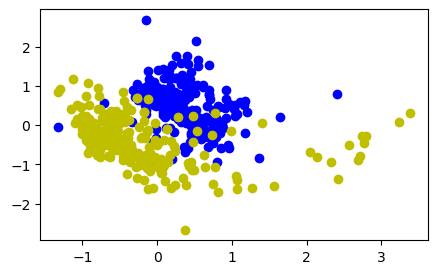

In [165]:
# plot two components
plt.figure(figsize=(5, 3))
plt.scatter(X_train_pca_scaled[cluster_idx, 1], X_train_pca_scaled[cluster_idx, 3], color='b')
plt.scatter(X_train_pca_scaled[star_idx, 1], X_train_pca_scaled[star_idx, 3], color='y')

Yeah, this looks like it should work pretty well!

Now that we're pretty confident this should work let's try again.

Accuracy: 0.411
Precision: 0.260
Recall: 0.137
f1 score: 0.179


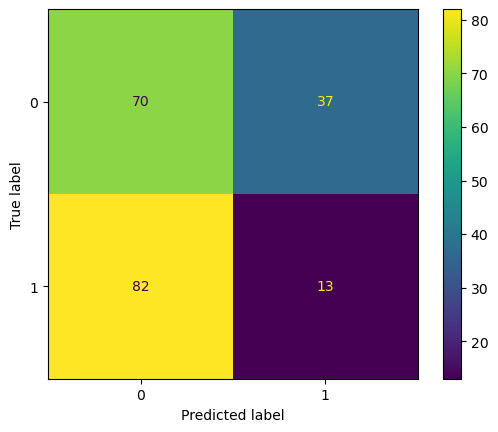

In [ ]:
gmm_model = GaussianMixture(n_components=2, random_state=91)
gmm_model.fit(X_train_pca_scaled, y_train)
y_pred = gmm_model.predict(X_test_pca_scaled)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"f1 score: {f1_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

Okay, well, it's still not doing a good job. Despite seeing that the principle component distributions are somewhat bimodal, the model didn't do a good job.

After messing around with the model a bit, I figured out that I needed to select only a few of the principle components, not all of them. It turns out that if we give the GMM model too many useless features, that may hurt it's ability to find the global minimum. And that is what's happening in our case. So if we instead take just the features that we know are beneficial for classifying our data, that can give us better results.

Accuracy: 0.822
Precision: 0.831
Recall: 0.779
f1 score: 0.804


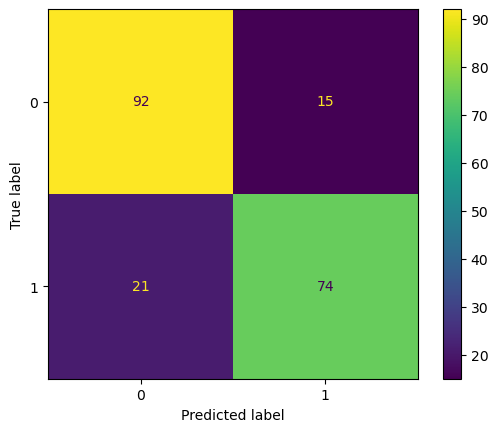

In [843]:
# try GMM model again, but only with a few of the more useful comonents
gmm_model = GaussianMixture(n_components=2, random_state=91)
features = [2, 3]
gmm_model.fit(X_train_pca_scaled[:, features], y_train)
y_pred = gmm_model.predict(X_test_pca_scaled[:, features])

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"f1 score: {f1_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

Wow, that is really good, let's see if these metrics are legit by running cross validation.

In [ ]:
# all PCs
cv_results = cross_validate(gmm_model, X_train_scaled[:, :], y_train, cv=5, scoring=('accuracy', 'precision', 'recall'))
pd.DataFrame(cv_results).mean(axis=0)

fit_time          0.002087
score_time        0.002337
test_accuracy     0.470899
test_precision    0.275282
test_recall       0.414220
dtype: float64

In [ ]:
# select PCs
features = [2, 4]
cv_results = cross_validate(gmm_model, X_train_scaled[:, features], y_train, cv=5, scoring=('accuracy', 'precision', 'recall'))
pd.DataFrame(cv_results).mean(axis=0)

fit_time          0.010729
score_time        0.002353
test_accuracy     0.629192
test_precision    0.553877
test_recall       0.733793
dtype: float64

In [ ]:
# different set of select PCs
features = [2, 3]
cv_results = cross_validate(gmm_model, X_train_pca_scaled[:, features], y_train, cv=5, scoring=('accuracy', 'precision', 'recall'))
pd.DataFrame(cv_results).mean(axis=0)

fit_time          0.002218
score_time        0.002335
test_accuracy     0.541661
test_precision    0.497801
test_recall       0.859476
dtype: float64

They definitely aren't >0.95 good, but we can confirm with cross validation that our score has increased. The problem seemed to be more that we were using useless features, than that we needed to use PCA. But PCA seems to have bumped up our recall score a bit as well, so we'll keep that. 

Now, we can use both PCA and selective features to find the global minimum, and then try to tune the GMM hyperparameters to get the optimal model.

In [838]:
# tune the GMM model hyperparameters to get an even better model
features = [2, 3]
parameters = {'tol': [0.1, 0.01], 'covariance_type': ['full', 'spherical'], 'init_params': ['kmeans', 'k-means++', 'random']}
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=91)
# reg_covar, max_iter doesn't matter

grid_gmm = GridSearchCV(GaussianMixture(n_components=2, random_state=91), parameters, scoring=['accuracy', 'recall', 'precision'], refit='recall', cv=cv)
grid_gmm.fit(X_train_pca_scaled[:, features], y_train)

pd.DataFrame(grid_gmm.cv_results_).loc[:, ['params', 'mean_test_accuracy', 'mean_test_recall', 'std_test_recall', 'mean_test_precision']]

,params,mean_test_accuracy,mean_test_recall,std_test_recall,mean_test_precision
0,"{'covariance_type': 'full', 'init_params': 'km...",0.529787,0.515515,0.281284,0.451470
1,"{'covariance_type': 'full', 'init_params': 'km...",0.534043,0.501070,0.304041,0.445272
2,"{'covariance_type': 'full', 'init_params': 'k-...",0.523404,0.675678,0.292388,0.466809
3,"{'covariance_type': 'full', 'init_params': 'k-...",0.519149,0.651789,0.313459,0.455373
4,"{'covariance_type': 'full', 'init_params': 'ra...",0.434043,0.634661,0.195658,0.412038
5,"{'covariance_type': 'full', 'init_params': 'ra...",0.434043,0.634661,0.195658,0.412038
6,"{'covariance_type': 'spherical', 'init_params'...",0.521277,0.474214,0.366541,0.407483
7,"{'covariance_type': 'spherical', 'init_params'...",0.504255,0.442114,0.392713,0.356910
8,"{'covariance_type': 'spherical', 'init_params'...",0.506383,0.703266,0.250670,0.459477
9,"{'covariance_type': 'spherical', 'init_params'...",0.497872,0.704932,0.272323,0.448733


Using this grid search, we will go with the "spherical" covariance and a tolerance of 0.1. The grid search results do not look nearly as good as the first attempt, but we didn't use cross-validation there, so the generalization scores weren't representing the actual generalization score very well. The best recall score we can get is about 0.74, and the best accuracy is 0.54. Not very good compared to the SVM and tree-based models, but better than where we started.

In [1134]:
# constructing our final GMM model with CV
cv_results_array = None

for i in range(100):
    # create best model based on our grid searches
    gmm_model = GaussianMixture(n_components=2, tol=0.1, covariance_type='spherical', init_params='kmeans', random_state=i)
    features = [2, 3]
    cv_results = cross_validate(gmm_model, X_train_pca_scaled[:, features], y_train, cv=5, scoring=('accuracy', 'precision', 'recall'))
    # create the new column to add, np.newaxis helps set this up
    new_col = pd.DataFrame(cv_results).mean(axis=0).iloc[2:5].values[:, np.newaxis]

    # if on first iteration, set array to new_col, else append new_col
    if cv_results_array is None:
        cv_results_array = new_col
    else:
        cv_results_array = np.append(cv_results_array, new_col, axis=1)

acc_prec_rec = ['accuracy', 'precision', 'recall']

for i, score in enumerate(acc_prec_rec):
    print(score, 'score:', round(cv_results_array.mean(axis=1)[i], 4), '+-', round(cv_results_array.std(axis=1)[i], 10))

accuracy score: 0.4933 +- 0.06268146
precision score: 0.3911 +- 0.1066932391
recall score: 0.4771 +- 0.2273411205



Best GMM Model Metrics:
Accuracy: 0.535
Precision: 0.503
Recall: 0.895
f1 score: 0.644


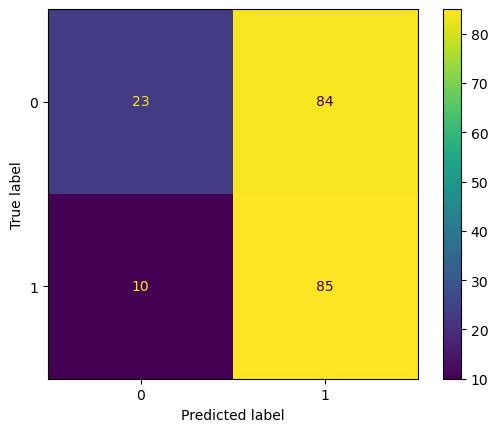

In [1125]:
# best model we found after grid searching
gmm_model_best = GaussianMixture(n_components=2, tol=0.1, covariance_type='spherical', init_params='kmeans', random_state=91)
gmm_model_best.fit(X_train_pca_scaled[:, features], y_train)
y_pred = gmm_model_best.predict(X_test_pca_scaled[:, features])

print('')
print('Best GMM Model Metrics:')
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"f1 score: {f1_score(y_test, y_pred):.3f}")

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

In [1126]:
# now using GMM to get probabilities
label_dict = {0: 'star', 1: 'GC'}
true_labels = [label_dict[i] for i in y_test]
print(true_labels)
for i in range(20):
    print('Probability of being     star:', round(gmm_model_best.predict_proba(X_test_pca_scaled[:, features])[i][0], 2), '     GC:', round(gmm_model_best.predict_proba(X_test_pca_scaled[:, features])[i][1], 2), 
    '   True label:', true_labels[i])

['GC', 'star', 'GC', 'star', 'GC', 'GC', 'GC', 'star', 'GC', 'star', 'star', 'star', 'star', 'star', 'star', 'GC', 'GC', 'GC', 'GC', 'star', 'star', 'star', 'star', 'star', 'GC', 'GC', 'star', 'GC', 'star', 'GC', 'star', 'star', 'star', 'GC', 'GC', 'GC', 'GC', 'GC', 'star', 'GC', 'GC', 'star', 'GC', 'star', 'GC', 'star', 'star', 'GC', 'star', 'star', 'star', 'star', 'star', 'GC', 'star', 'star', 'star', 'GC', 'GC', 'GC', 'star', 'star', 'GC', 'star', 'star', 'GC', 'star', 'GC', 'star', 'star', 'GC', 'star', 'GC', 'GC', 'star', 'GC', 'star', 'GC', 'GC', 'GC', 'GC', 'GC', 'GC', 'GC', 'star', 'star', 'GC', 'star', 'GC', 'star', 'GC', 'GC', 'GC', 'star', 'star', 'star', 'GC', 'star', 'GC', 'star', 'star', 'GC', 'star', 'GC', 'star', 'GC', 'star', 'star', 'star', 'GC', 'star', 'star', 'star', 'star', 'star', 'star', 'star', 'GC', 'star', 'star', 'star', 'GC', 'star', 'GC', 'GC', 'GC', 'star', 'GC', 'GC', 'star', 'star', 'star', 'GC', 'GC', 'GC', 'GC', 'GC', 'GC', 'GC', 'star', 'star', 'GC',

Success! We are able to get probabilities for each data point. However, this GMM model is not nearly as our SVM model, so we may want to use the "predict_proba" function of that model instead.

In [1127]:
# now using SVM to get probabilities
svc_best_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svc_best_model.fit(X_train_scaled, y_train)
y_pred = svc_best_model.predict(X_test_scaled)

print('')
print('Non-CV results:')
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"f1 score: {f1_score(y_test, y_pred):.3f}")

label_dict = {0: 'star', 1: 'GC'}
true_labels = [label_dict[i] for i in y_test]
for i in range(20):
    print('Probability of being     star:', round(svc_best_model.predict_proba(X_test_scaled)[i][0], 2), '     GC:', round(svc_best_model.predict_proba(X_test_scaled)[i][1], 2), 
    '   True label:', true_labels[i])


Non-CV results:
Accuracy: 0.975
Precision: 0.989
Recall: 0.958
f1 score: 0.973
Probability of being     star: 0.0      GC: 1.0    True label: GC
Probability of being     star: 1.0      GC: 0.0    True label: star
Probability of being     star: 0.18      GC: 0.82    True label: GC
Probability of being     star: 1.0      GC: 0.0    True label: star
Probability of being     star: 0.98      GC: 0.02    True label: GC
Probability of being     star: 0.03      GC: 0.97    True label: GC
Probability of being     star: 0.08      GC: 0.92    True label: GC
Probability of being     star: 1.0      GC: 0.0    True label: star
Probability of being     star: 0.0      GC: 1.0    True label: GC
Probability of being     star: 1.0      GC: 0.0    True label: star
Probability of being     star: 0.93      GC: 0.07    True label: star
Probability of being     star: 0.99      GC: 0.01    True label: star
Probability of being     star: 0.96      GC: 0.04    True label: star
Probability of being     star: 1.0

Overall, we have several good avenues we could use if we needed to actually apply probabilities to this classification problem. I would likely choose the SVM model over the GMM model right now, however.

# 4. Final Results and Reflection

I put all of the code of my optimizations, dimensionallity reduction, and GMM attempts in section 3.5, so that I could include just writing in this section, describing the results of these strings of experiments.

Overall, we constructed 3 great classifier models for the proposed problem, as well as a decent GMM model. Scaling was integral to producing good results for all models, and principle component analysis and feature selection were important for GMM. Grid searches allowed us to inspect the hyperparameter space of each model, and let us optimize each model a little bit more than the default models allowed.

Specifically, for the decision tree model, we did a grid search changing the criterion, the max_depth, min_samples_split, and min_samples_leaf. The best set of hyperparameters we found was 'gini' criterion, max_depth of anything above ~6 (we chose 6), min_samples leaf of 1, and min_samples_split didn't matter much so we chose 2.

For the Random Forest model, we did a grid search changing n_estimators and max_depth, but as the random forest was so stable, the hyperparameters didn't much tuning, so we only had to increase the n_estimators parameter to 1000.

For SVM the hyperparameters didn't affect the metrics by much besides the kernel (which was by far best with radial-basis function kernel), so we just used C=1 and gamma='scale' to keep the model simple.

The main metrics we used for each model are shown below to compare and contrast models, including first the results of our cross validation with the training dataset, and then second, the final metrics of the best models using the test dataset.

---
**Using Cross Validation with the training dataset**

Decision Tree Metrics (many seeds)
* accuracy score: 0.9634 +- 0.004
* precision score: 0.9656 +- 0.007
* recall score: 0.9567 +- 0.006

Random Forest Metrics (several seeds)
* accuracy score: 0.9802 +- 0.003
* precision score: 0.9901 +- 0.007
* recall score: 0.9675 +- 0.005

SVM Metrics (different seeds don't affect models)
* accuracy score: 0.9872 +- 0.0
* precision score: 0.9866 +- 0.0
* recall score: 0.9864 +- 0.0

GMM Metrics (many seeds)
* accuracy score: 0.4933 +- 0.06268146
* precision score: 0.3911 +- 0.1066932391
* recall score: 0.4771 +- 0.2273411205

---

**Final Metrics using the test dataset** 

Best Decision Tree Model Metrics:
* Accuracy: 0.921
* Precision: 0.934
* Recall: 0.895
* f1 score: 0.914

Best Random Forest Model Metrics:
* Accuracy: 0.980
* Precision: 1.000
* Recall: 0.958
* f1 score: 0.978

Best SVM Model Metrics:
* Accuracy: 0.985
* Precision: 1.000
* Recall: 0.968
* f1 score: 0.984

Best GMM Model Metrics:
* Accuracy: 0.535
* Precision: 0.503
* Recall: 0.895
* f1 score: 0.644

---

I think that these metrics highlight how useful they are to solve this problem of identifying globular clusters with lick indices. Each model works well, and random forest has perfect precision on the test dataset, while SVM has the best recall and perfect precision. If you really wanted to get the best of both of these models, you could make a stacked classifier out of the two, which might produce even better metrics. Additionally, the cross validation results of the training data show that the uncertainty of these models are pretty small.

I would be very curious if this only worked so well because the Lick indices I got from the papers I found were so accurate, or if even Lick indices from lower resolution spectra would allow as accurate of a classification.

# 5. Link to Github repo

https://github.com/evanrootness/final-project.git

# 6. AI Statement


I found out about Numpy's function, np.newaxis, when trying to figure out a clean way to initialize numpy arrays. It's basically what it sounds like, a placeholder for whatever axis you want it to be. I used it in this line;
    new_col = pd.DataFrame(cv_results).mean(axis=0).iloc[2:5].values[:, np.newaxis]


